In [1]:
#to avoid an inconsistency in cuda version, we have to use an older version of pytorch 
!pip3 install torch==1.7.0 torchvision==0.8.1 -f https://download.pytorch.org/whl/cu101/torch_stable.html
!pip3 install torchvision

!pip3 install tqdm

import copy
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
import gc
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)
import io
import pickle
import zipfile

import torchvision
from torchvision import datasets, transforms
import IPython

from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive')

print("pytorch cuda version: ", torch.version.cuda)
print("torchvision cuda version: ", torchvision.version.cuda)
assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"


#audio processing imports (this will reinstall pytorch for some reason, but at least it keeps the compatability with cuda)

!pip3 install torchaudio
import torchaudio
from scipy import signal
import librosa
from scipy.io.wavfile import read, write


Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Mounted at /content/gdrive
pytorch cuda version:  10.1
torchvision cuda version:  10010
     |████████████████████████████████| 7.6MB 15.1MB/s 
     |████████████████████████████████| 776.8MB 22kB/s 
ERROR: torchvision 0.8.1+cu101 has requirement torch==1.7.0, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101


/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


# turn audio into spectrograms (Don't Run Again)
This was part of the process to train the network, so if you just want to run the style transfer, skip down to the transfer network section

In [ ]:
#don't run this again
#this is work to be done prior to training the network to speed up the process.


path = '/content/gdrive/My Drive/Audio Style Transfer/IRMAS-TrainingData'
spec_path = '/content/gdrive/My Drive/Audio Style Transfer/spectro/train'
spec_path_val = '/content/gdrive/My Drive/Audio Style Transfer/spectro/val'

directories = os.listdir(path)
directories = directories[:-1]
print(directories)
for d in directories:
  d_path = os.path.join(path,d)
  files =  [f for f in os.listdir(d_path) if os.path.isfile(os.path.join(d_path, f))]

  print(d)
  for i in range(250):
    p = os.path.join(d_path,files[i])
    data, rate = torchaudio.load(p)
    nfft = 1028
    Zxx = torch.stft(data, n_fft=nfft, normalized = False)
    Zxx = Zxx[0,:,:,:].numpy()
    #save the info
    np.save(os.path.join(spec_path,d,str(i)+'.npy'), Zxx)
  
  for i in range(250,350):
    p = os.path.join(d_path,files[i])
    data, rate = torchaudio.load(p)
    nfft = 1028
    Zxx = torch.stft(data, n_fft=nfft, normalized = False)
    Zxx = Zxx[0,:,:,:].numpy()
    #save the info
    np.save(os.path.join(spec_path_val,d,str(i)+'.npy'), Zxx)



# Here we create our Dataset Folder

In [2]:
#this is for the pytorch stft's
batch_size = 10
lr = 0.0002
train_epoch = 3

n_fft = 1028
normalized = False

#download the data, and change the filepath
Extensions = ('.npy')
train_dataset = datasets.DatasetFolder(root='/content/gdrive/My Drive/Audio Style Transfer/spectro/train',
                           transform=transforms.Compose([
                               transforms.ToTensor()
                           ]),
                           extensions = Extensions,
                           loader=np.load)

val_dataset = datasets.DatasetFolder(root='/content/gdrive/My Drive/Audio Style Transfer/spectro/val',
                           transform=transforms.Compose([
                               transforms.ToTensor()
                           ]),
                           extensions = Extensions,
                           loader=np.load)


##### Create the dataloader #####
# train_loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

#here is the network

In [3]:
class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.456, 0.406]).cuda(), std=torch.tensor([0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, Zxx):
      # print(Zxx.shape)
      # print(self.mean.shape)
      # print(self.std.shape)
      return (Zxx - self.mean) / self.std


In [17]:
#here is our model

class AudioClassifier(nn.Module):
  def __init__(self, dataset):
    super().__init__()
    x, y = dataset[0]
    c,h,w = x.size()
    print("\n the input sizes are: ", c,h,w)
    out = 11

    self.conv1 = nn.Conv2d(c, 4, kernel_size = (3,1))
    self.conv2 = nn.Conv2d(4, 8, kernel_size = (3,1))
    self.conv3 = nn.Conv2d(8, 16, kernel_size = (3,1))
    self.conv4 = nn.Conv2d(16, 32, kernel_size = (3,1))
    self.conv5 = nn.Conv2d(32, 64, kernel_size = (3,1))

    self.relu = nn.ReLU(inplace = False) #not sure if the inplace thing is necessary
    self.maxp = nn.MaxPool2d(kernel_size=(3, 1), stride = (3,1))
    # self.maxp9 = nn.MaxPool2d(kernel_size=(9, 1), stride = (9,1))
    self.maxp2 = nn.MaxPool2d(kernel_size=(1,3), stride = (1,3))
    
    self.conv6 = nn.Conv2d(64, 64, kernel_size = (1,3))
    self.conv7 = nn.Conv2d(64, 64, kernel_size = (1,3))
    self.conv8 = nn.Conv2d(64, 64, kernel_size = (1,3))
    
    self.drop_out = nn.Dropout()
    self.flatten = nn.Flatten(1,-1)
    self.fully_connected = nn.Linear(1152, out)

    self.norm = Normalization().eval()

 
    
  def forward(self, input):
    input = self.norm(input)

    output = self.conv1(input)
    output = self.relu(output)
    output = self.maxp(output)
    # print("output size 1: ", output.shape)

    output = self.conv2(output)
    output = self.relu(output)
    output = self.maxp(output)
    # print("output size 2: ", output.shape)

    output = self.conv3(output)
    output = self.relu(output)
    output = self.maxp(output)
    # print("output size3: ", output.shape)

    output = self.conv4(output)
    output = self.relu(output)
    output = self.maxp(output)
    # print("output size 4: ", output.shape)

    output = self.conv5(output)
    output = self.relu(output)
    output = self.maxp(output)
    # print("output size 5: ", output.shape)

    output = self.conv6(output)
    output = self.relu(output)
    output = self.maxp2(output)
    # print("output size 6: ", output.shape)

    output = self.conv7(output)
    output = self.relu(output)
    output = self.maxp2(output)
    # print("output size 7: ", output.shape)

    output = self.conv8(output)
    output = self.relu(output)
    output = self.maxp2(output)
    # print("output size 8: ", output.shape)

    output = self.flatten(output)
    # print("output size 9: ", output.shape)

    output = self.drop_out(output)
    output = self.fully_connected(output)
    # print("output size 10: ", output.shape)

    return output.squeeze(1).squeeze(1)



# Train the network


In [18]:

def scope():
  try:
    #code for calling dataset and dataloader
    model = AudioClassifier(train_dataset)
    model = model.cuda()
    objective = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)

    gc.collect()
    print(torch.cuda.memory_allocated(0) / 1e9)
    
    losses_train = []
    losses_val = []
    
    acc_ = []
    start = time.time()
    
    for epoch in range(10):
      
      gc.collect()
      
      accuracy_batch = []
      
      loop = tqdm(total=len(train_loader), position=0, leave=False)
      
      for batch, (x,y_truth) in enumerate(train_loader):
        
        x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)
        optimizer.zero_grad()
        y_hat = model(x) 

        loss = objective(y_hat, y_truth.long())
        loss.backward()
        losses_train.append((time.time()-start, loss.item()))

        accuracy = (torch.softmax(y_hat, 1).argmax(1) == y_truth).float().mean()
        accuracy_batch.append(accuracy.item())
        
        loop.set_description('epoch:{}, loss:{:.4f},accuracy:{:.3f}'.format(epoch,loss.item(),accuracy))
        loop.update(1)
        
        optimizer.step()
        
        if batch % 100 == 0:
          val = np.mean([objective(model(x.cuda()), y.cuda().long()).item() for x,y in val_loader])
          losses_val.append((time.time()-start, val))

      acc_.append(np.mean(accuracy_batch))
      
    loop.close()
    
  except:
    #__ITB__()
    raise

  #save the model before we lose it
  torch.save(model, '/content/gdrive/My Drive/Audio Style Transfer/model.pt')

  return losses_train, losses_val, model, acc_
    
lt, lv, m, acc = scope()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
  0%|          | 0/250 [00:00<?, ?it/s]


 the input sizes are:  2 515 515
0.088671232


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: This overload of cuda is deprecated:
	cuda(torch.device device, bool async, *, torch.memory_format memory_format)
Consider using one of the following signatures instead:
	cuda(torch.device device, bool non_blocking, *, torch.memory_format memory_format) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)


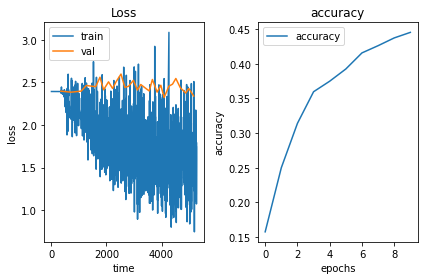

[0.15760000306367875, 0.25000000500679015, 0.31400000628829, 0.359600006878376, 0.3748000068664551, 0.3924000074863434, 0.4156000061929226, 0.42600000634789464, 0.4372000067234039, 0.4452000073492527]


In [19]:
#plot stuff
a,b = zip(*lv)
c,d = zip(*lt)
plt.subplot(121)
plt.plot(c,d, label = 'train')
plt.plot(a,b, label='val')
plt.legend()
plt.xlabel('time')
plt.ylabel('loss')
plt.title("Loss")
plt.subplot(122)
plt.plot(acc, label = 'accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title("accuracy")
plt.tight_layout()
plt.show()

#here is our transfer network

load the model
.pt file should be included. Change directory so that it can access the model.pt file.

In [20]:
model = torch.load('/content/gdrive/My Drive/Audio Style Transfer/model.pt')

In [6]:


class AudioIntermediate(nn.Module):
  def __init__(self, requested=[], m=model):
    super(AudioIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.AudioT = m.eval()
    for i, m in enumerate(self.AudioT.children()):
      print(self.AudioT.children())
      if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
        m.inplace = False          # the model has a hard time going backwards on the in place functions. 
      
      if i in requested:
        def curry(i):
          def hook(module, input, output):
            self.intermediates[i] = output
          return hook
        m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.Audio(x)
    return self.intermediates
  
  

#here are the layers we want to base our style on 


In [7]:
#Print the available layers
for i, t in enumerate(model.eval().children()):
  print(i, t)

0 Conv2d(2, 4, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
1 Conv2d(4, 8, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
2 Conv2d(8, 16, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
3 Conv2d(16, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
4 Conv2d(32, 64, kernel_size=(3, 1), stride=(1, 1))
5 ReLU()
6 MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
7 MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
8 Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
9 Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
10 Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
11 Dropout(p=0.5, inplace=False)
12 Flatten(start_dim=1, end_dim=-1)
13 Linear(in_features=1216, out_features=11, bias=True)
14 Normalization()


In [39]:
#these names need to be in the same order as in the network
audio_names = ['Conv2d_1', 'Conv2d_2', 'Conv2d_3', 'Conv2d_4', 'Conv2d_5', 'ReLU', 'MaxPool2d_1', 'MaxPool2d_2', 'Conv2d_6', 'Conv2d_7', 'Conv2d_8', 'Dropout', 'Flatten', 'Linear_1', 'Normalization']
# Choose the layers to use for style and content transfer 
#content layer names
cl = ['Conv2d_5', 'Conv2d_6', 'Conv2d_7']
#style layer names
sl = ['Conv2d_1', 'Conv2d_2', 'Conv2d_3']
content_layers_default = [audio_names.index(i) for i in cl ]
style_layers_default = [audio_names.index(i) for i in sl ]

content_layer_activs = AudioIntermediate(requested=content_layers_default, m=model).cuda()
style_layer_activs = AudioIntermediate(requested=style_layers_default, m=model).cuda()

<generator object Module.children at 0x7f30c9c40d00>
<generator object Module.children at 0x7f30c9c40d00>
<generator object Module.children at 0x7f30c9c40d00>
<generator object Module.children at 0x7f30c9c40d00>
<generator object Module.children at 0x7f30c9c40d00>
<generator object Module.children at 0x7f30c9c40d00>
<generator object Module.children at 0x7f30c9c40d00>
<generator object Module.children at 0x7f30c9c40d00>
<generator object Module.children at 0x7f30c9c40d00>
<generator object Module.children at 0x7f30c9c40d00>
<generator object Module.children at 0x7f30c9c40d00>
<generator object Module.children at 0x7f30c9c40d00>
<generator object Module.children at 0x7f30c9c40d00>
<generator object Module.children at 0x7f30c9c40d00>
<generator object Module.children at 0x7f30c9c40d00>
<generator object Module.children at 0x7f30c9c40d00>
<generator object Module.children at 0x7f30c9c40d00>
<generator object Module.children at 0x7f30c9c40d00>
<generator object Module.children at 0x7f30c9c

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


#here is the Gram matrix and Loss functions

In [40]:
#here is the gram matrix
def gram_matrix(input):
  b, f, h, w = input.size()
    
  features = input.view(b*f, h*w)

  basis = torch.mm(features, features.t())

  gram = basis.div(b*f*h*w)

  return gram
  
class ContentLoss(nn.Module):
  def __init__(self, target):
    super(ContentLoss, self).__init__()
    self.target = target.detach()
    
  def forward(self, input):
    self.loss = F.mse_loss(input, self.target)
    return input
    
class StyleLoss(nn.Module):
  def __init__(self, target_feature):
    super(StyleLoss, self).__init__()
    self.target = gram_matrix(target_feature).detach()
    
  def forward(self, input):
    G = gram_matrix(input)
    
    self.loss = F.mse_loss(G, self.target)
    
    return input

#Just a Function to help us get the losses


In [41]:
def get_style_model_and_losses(Audio_model, normalization_mean, normalization_std, 
                               content_Zxx, style_Zxx, 
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
  
  Audio_model = copy.deepcopy(Audio_model)
  
  normalization = Normalization(normalization_mean, normalization_std).cuda()
  
  #here are the things we are going to return:
  content_losses=[]
  style_losses=[]
  
  model=nn.Sequential(normalization)
  
  i = -1 #keep track of the convolution we're on
  for layer in Audio_model.children():
    i += 1
    if isinstance(layer, nn.Conv2d):
      #name = 'conv{}_1'.format(i)
      pass
    elif isinstance(layer, nn.ReLU):
      #name = 'relu_{}'.format(i)
      pass
      layer = nn.ReLU(inplace=False)
      
    elif isinstance(layer, nn.MaxPool2d):
      #name = 'pool_{}'.format(i)
      pass
    elif isinstance(layer, nn.BatchNorm2d):
      #name = 'bn_{}'.format(i)
      pass
    elif isinstance(layer, nn.Dropout):
      pass
    elif isinstance(layer, nn.Linear):
      pass
    # elif isinstance(layer, nn.Normalization):
    #   pass
    # else:
    #   raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
    name = audio_names[i]
    
    model.add_module(name, layer)
    
    if i in content_layers:
      target = model(content_Zxx).detach()
      content_loss = ContentLoss(target)
      model.add_module('content_loss_{}'.format(i), content_loss)
      content_losses.append(content_loss)
      
    if i in style_layers:
      target = model(style_Zxx).detach()
      style_loss = StyleLoss(target)
      model.add_module('style_loss_{}'.format(i), style_loss)
      style_losses.append(style_loss)
      
  j = 0
  for j in range(len(model)-1, -1, -1):
    if isinstance(model[j], ContentLoss) or isinstance(model[j], StyleLoss):
      break

  model = model[:(j+1)]
  
  return model, content_losses, style_losses



#More functions to simplify the end style transfer


In [42]:


def get_input_optimizer(input_Zxx):
  optimizer = optim.Adam([input_Zxx.requires_grad_()], lr = .1)
  return optimizer

def run_style_transfer(model, normalization_mean, normalization_std,
                      content_Zxx, style_Zxx, input_Zxx, num_steps=300,
                      style_weight=1000000, content_weight=1):
  
  print("Building the style transfer model...")
  model, content_losses, style_losses = get_style_model_and_losses(
      Audio_model, normalization_mean, normalization_std, content_Zxx, style_Zxx)
  
  print("Getting the optimizer...")
  optimizer = get_input_optimizer(input_Zxx)
  
  print("Optimizing...")
  run = [0]
  
  loop = tqdm(total=num_steps, position=0, leave=False)
  
  while run[0] <= num_steps:
    
    def closure():
      input_Zxx.data.clamp(0, 1)
      
      optimizer.zero_grad()
      model(input_Zxx)
      style_score = 0
      content_score = 0
      
      for sl in style_losses:
        style_score += sl.loss
        
      for cl in content_losses:
        content_score += cl.loss
        
      style_score *= style_weight
      content_score *= content_weight
      
      loss = style_score + content_score
      loss.backward()
      
      run[0] += 1
      if run[0] % 50 == 0:
        loop.set_description('Epoch:{} Style Loss: {:4f} Content Loss: {:4f}'.format(run[0], style_score.item(), content_score.item()))
        loop.update(50)
      
      return style_score + content_score
    
    optimizer.step(closure)
  input_Zxx.data.clamp_(0, 1)
  
  return input_Zxx

#Finally, we can run the thing

use the first box to upload some samples, or else use the second box to navigate to some files on google drive.

I haven't used the first option in a while, so it may need some debugging

In [47]:
#upload audio samples

def upload():
  print('Upload Content Audio')
  file1 = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Audio')
  file2 = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return file1, file1

content, style = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))



Upload Content Audio


NameError: ignored

In [48]:
#file names from google drive
content = '/content/gdrive/My Drive/Audio Style Transfer/Copy of 02 guitar dust weltschmerz interlude.wav'
style = '/content/gdrive/My Drive/Audio Style Transfer/Copy of 0-coast deathwork 1-2.wav'

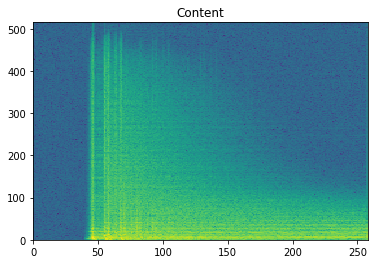

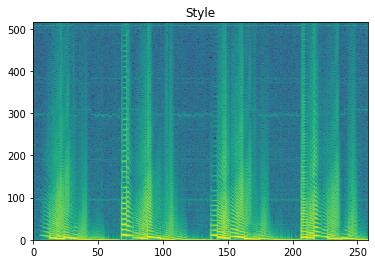

torch.Size([1, 2, 515, 515])
torch.Size([1, 2, 515, 515])


In [43]:

#cut audio and make sure the sampling rate is correct
nfft = 1028
#content audio
data1, rate1 = torchaudio.load(content)

data1 = data1[:, :132299]
content_Zxx = torch.stft(data1, n_fft=nfft, normalized = False).cuda()
specgram = torchaudio.transforms.Spectrogram(n_fft = nfft)(data1)
plt.pcolormesh(specgram.log2()[0,:,:].numpy())
plt.title('Content')
plt.show()


#style audio
data2, rate2 = torchaudio.load(style)
if rate2 != rate1:
  raise ValueError("wrong sampling rate")
data2 = data2[:, :132299]
style_Zxx = torch.stft(data2, n_fft=nfft, normalized = False).cuda()
specgram = torchaudio.transforms.Spectrogram(n_fft = nfft)(data2)
plt.pcolormesh(specgram.log2()[0,:,:].numpy())
plt.title('Style')
plt.show()

content_Zxx = content_Zxx[0].transpose(0,-1).transpose(2,1).unsqueeze(dim = 0) #
print(content_Zxx.shape)

style_Zxx = style_Zxx[0].transpose(0,-1).transpose(2,1).unsqueeze(dim = 0) #
print(style_Zxx.shape)

display the original audio:
content, then style

In [38]:
IPython.display.Audio(data=data1, rate=rate1)


In [39]:
IPython.display.Audio(data=data2, rate=rate2)

# This box actually does the style trasfer operation


In [44]:
cnn_normalization_mean = torch.tensor([0.456, 0.406]).cuda() #[0.456, 0.406]
cnn_normalization_std = torch.tensor([0.224, 0.225]).cuda() #[0.224, 0.225]

print(content_Zxx.shape)
print(style_Zxx.shape)

# Audio_model = m.features.cuda().eval()
Audio_model = model

# Start with a copy of the content Zxx
input_Zxx = content_Zxx.clone()

output = run_style_transfer(Audio_model, cnn_normalization_mean, cnn_normalization_std, content_Zxx, style_Zxx, input_Zxx)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
  0%|          | 0/300 [00:00<?, ?it/s]

torch.Size([1, 2, 515, 515])
torch.Size([1, 2, 515, 515])
Building the style transfer model...
Getting the optimizer...
Optimizing...


# transfer back to audio


In [45]:

output_ = output.squeeze()
output_ = output_.transpose(0,-1).transpose(0,1).unsqueeze(dim = 0).cpu() #
print(output_.shape)

nfft = 1028
rate = 44100
xrec = torch.istft(output_, n_fft=nfft, normalized = False)

xrec = xrec.detach().numpy()
print(xrec)
# wav_file = write('output_.wav')
IPython.display.Audio(data=xrec, rate=rate)


torch.Size([1, 515, 515, 2])
[[-0.0009699  -0.0016954  -0.00095991 ...  0.0191545   0.02259202
   0.01906612]]


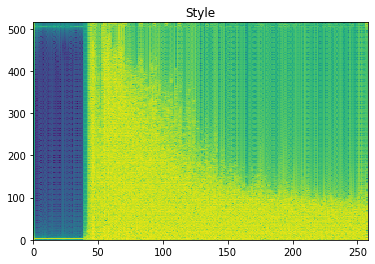

In [46]:
specgram = torchaudio.transforms.Spectrogram(n_fft = nfft)(torch.Tensor(xrec))
plt.pcolormesh(specgram.log2()[0,:,:].numpy())
plt.title('Style')
plt.show()

#as you can see, it mostly just adds noise